Using device: cuda


>>> Handling LSTM Model <<<

[INFO] Found existing extended_prediction_best_model_LSTM.pt. Loading without re-training...
LSTM -> Test Loss (Huber): 46.553429
LSTM -> Test MAPE:        3.17%
LSTM -> Test Accuracy:    96.83%
LSTM -> Test MSE:         2554.752257


>>> Handling GRU Model <<<

[INFO] Found existing extended_prediction_best_model_GRU.pt. Loading without re-training...
GRU -> Test Loss (Huber): 32.922932
GRU -> Test MAPE:        2.24%
GRU -> Test Accuracy:    97.76%
GRU -> Test MSE:         1463.354985


>>> Handling RNN Model <<<

[INFO] Found existing extended_prediction_best_model_RNN.pt. Loading without re-training...
RNN -> Test Loss (Huber): 15.907505
RNN -> Test MAPE:        1.10%
RNN -> Test Accuracy:    98.90%
RNN -> Test MSE:         390.384645


>>> Handling CNN Model <<<

[INFO] Found existing extended_prediction_best_model_CNN.pt. Loading without re-training...
CNN -> Test Loss (Huber): 55.302361
CNN -> Test MAPE:        3.76%
CNN -> Test A

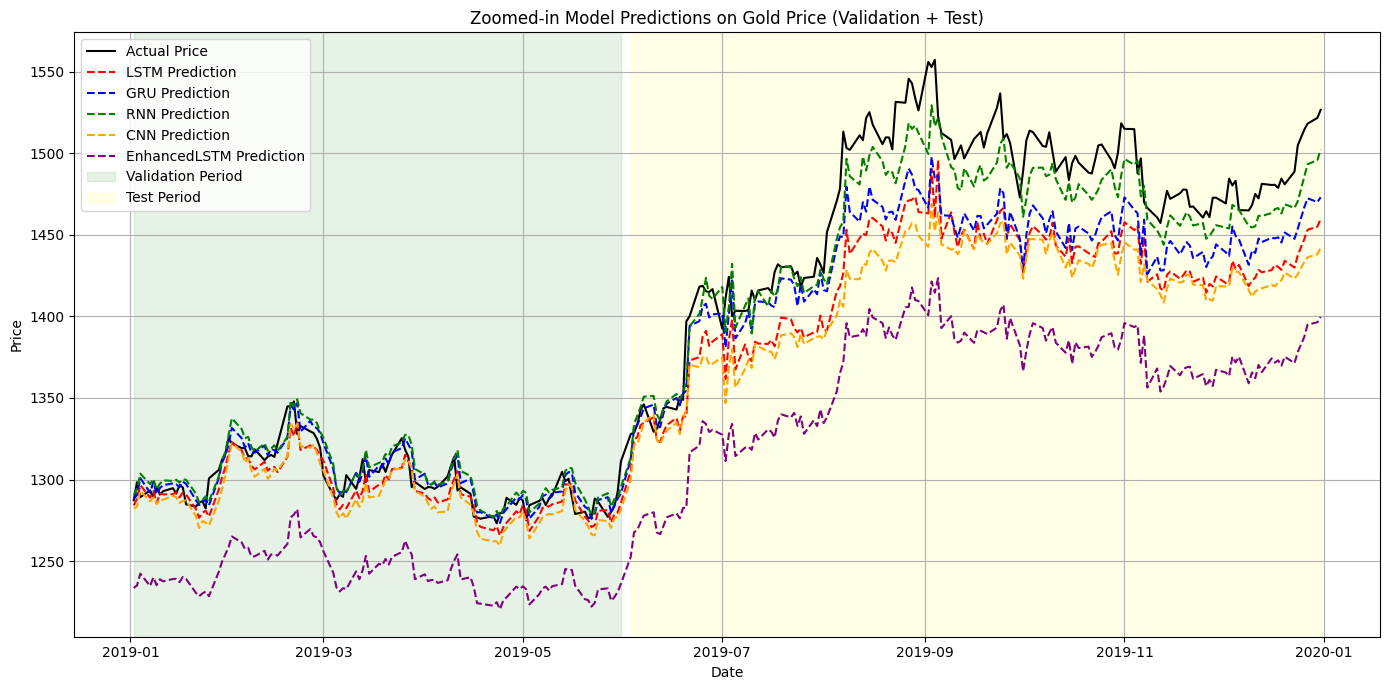

Lowest Validation MSE -> ('EnhancedLSTM', 31, 154.58517156570022)
Highest Validation R²   -> ('Actual', 31, 0.9735302077358385)


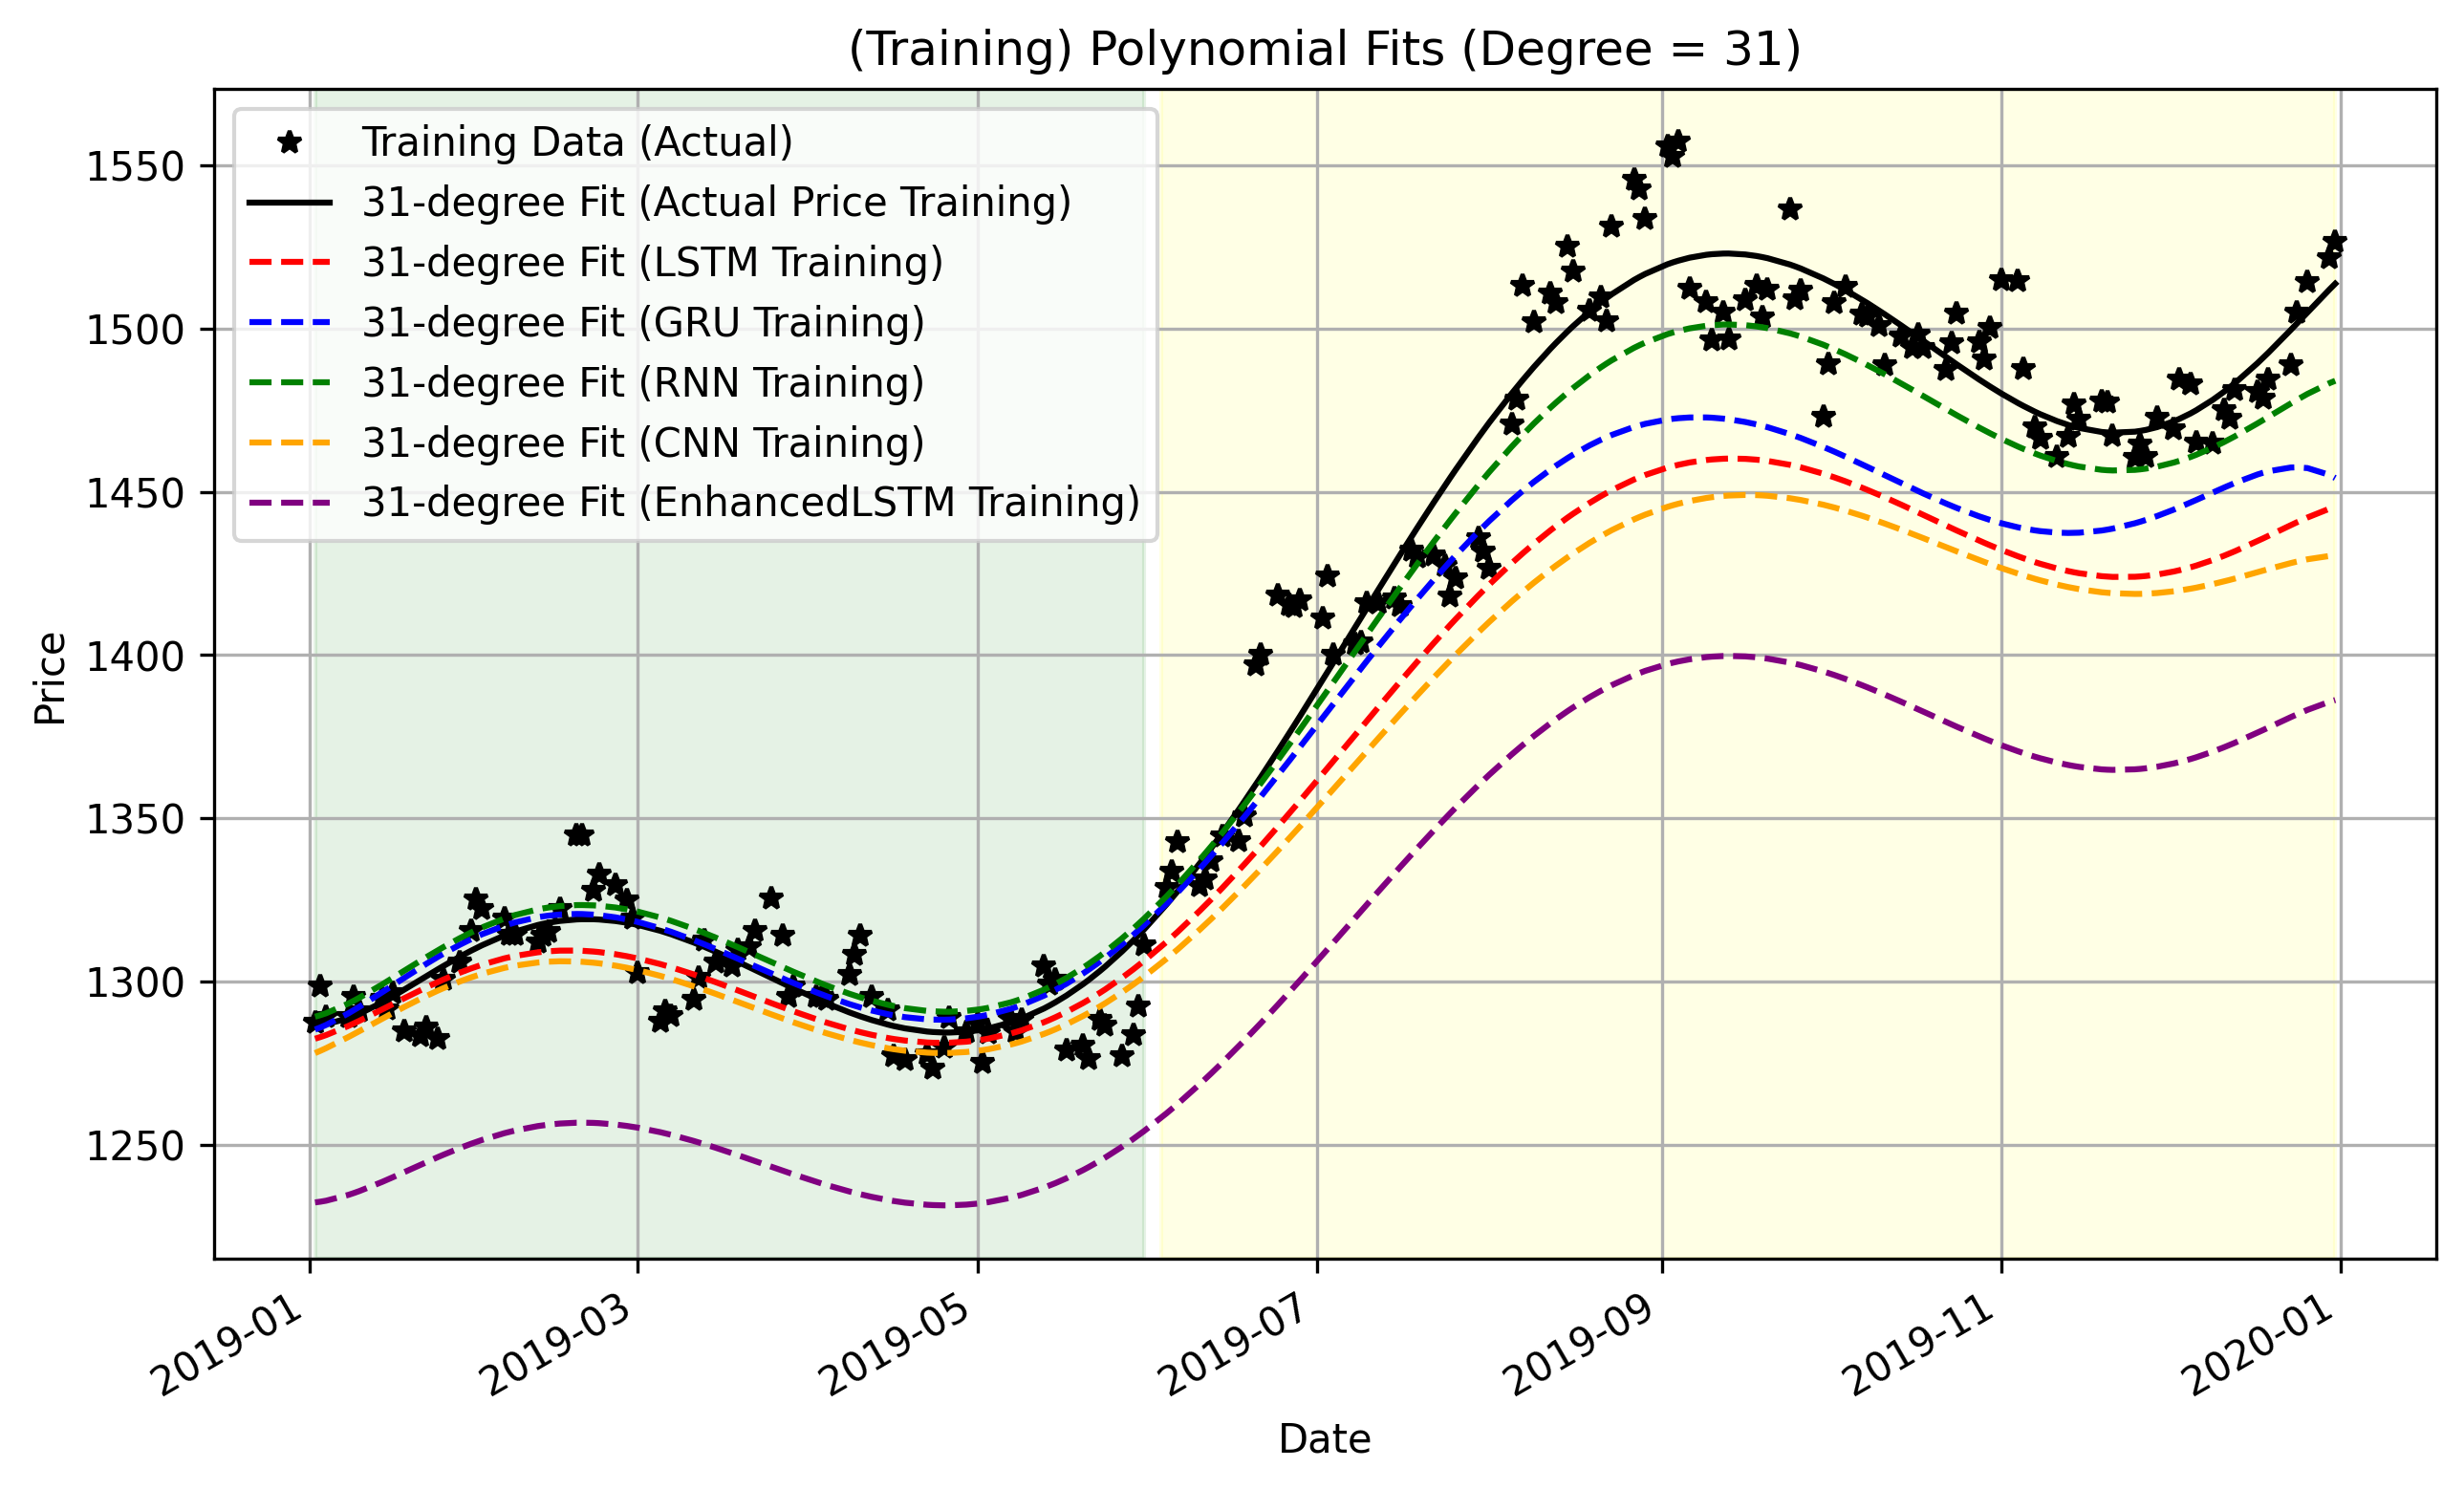

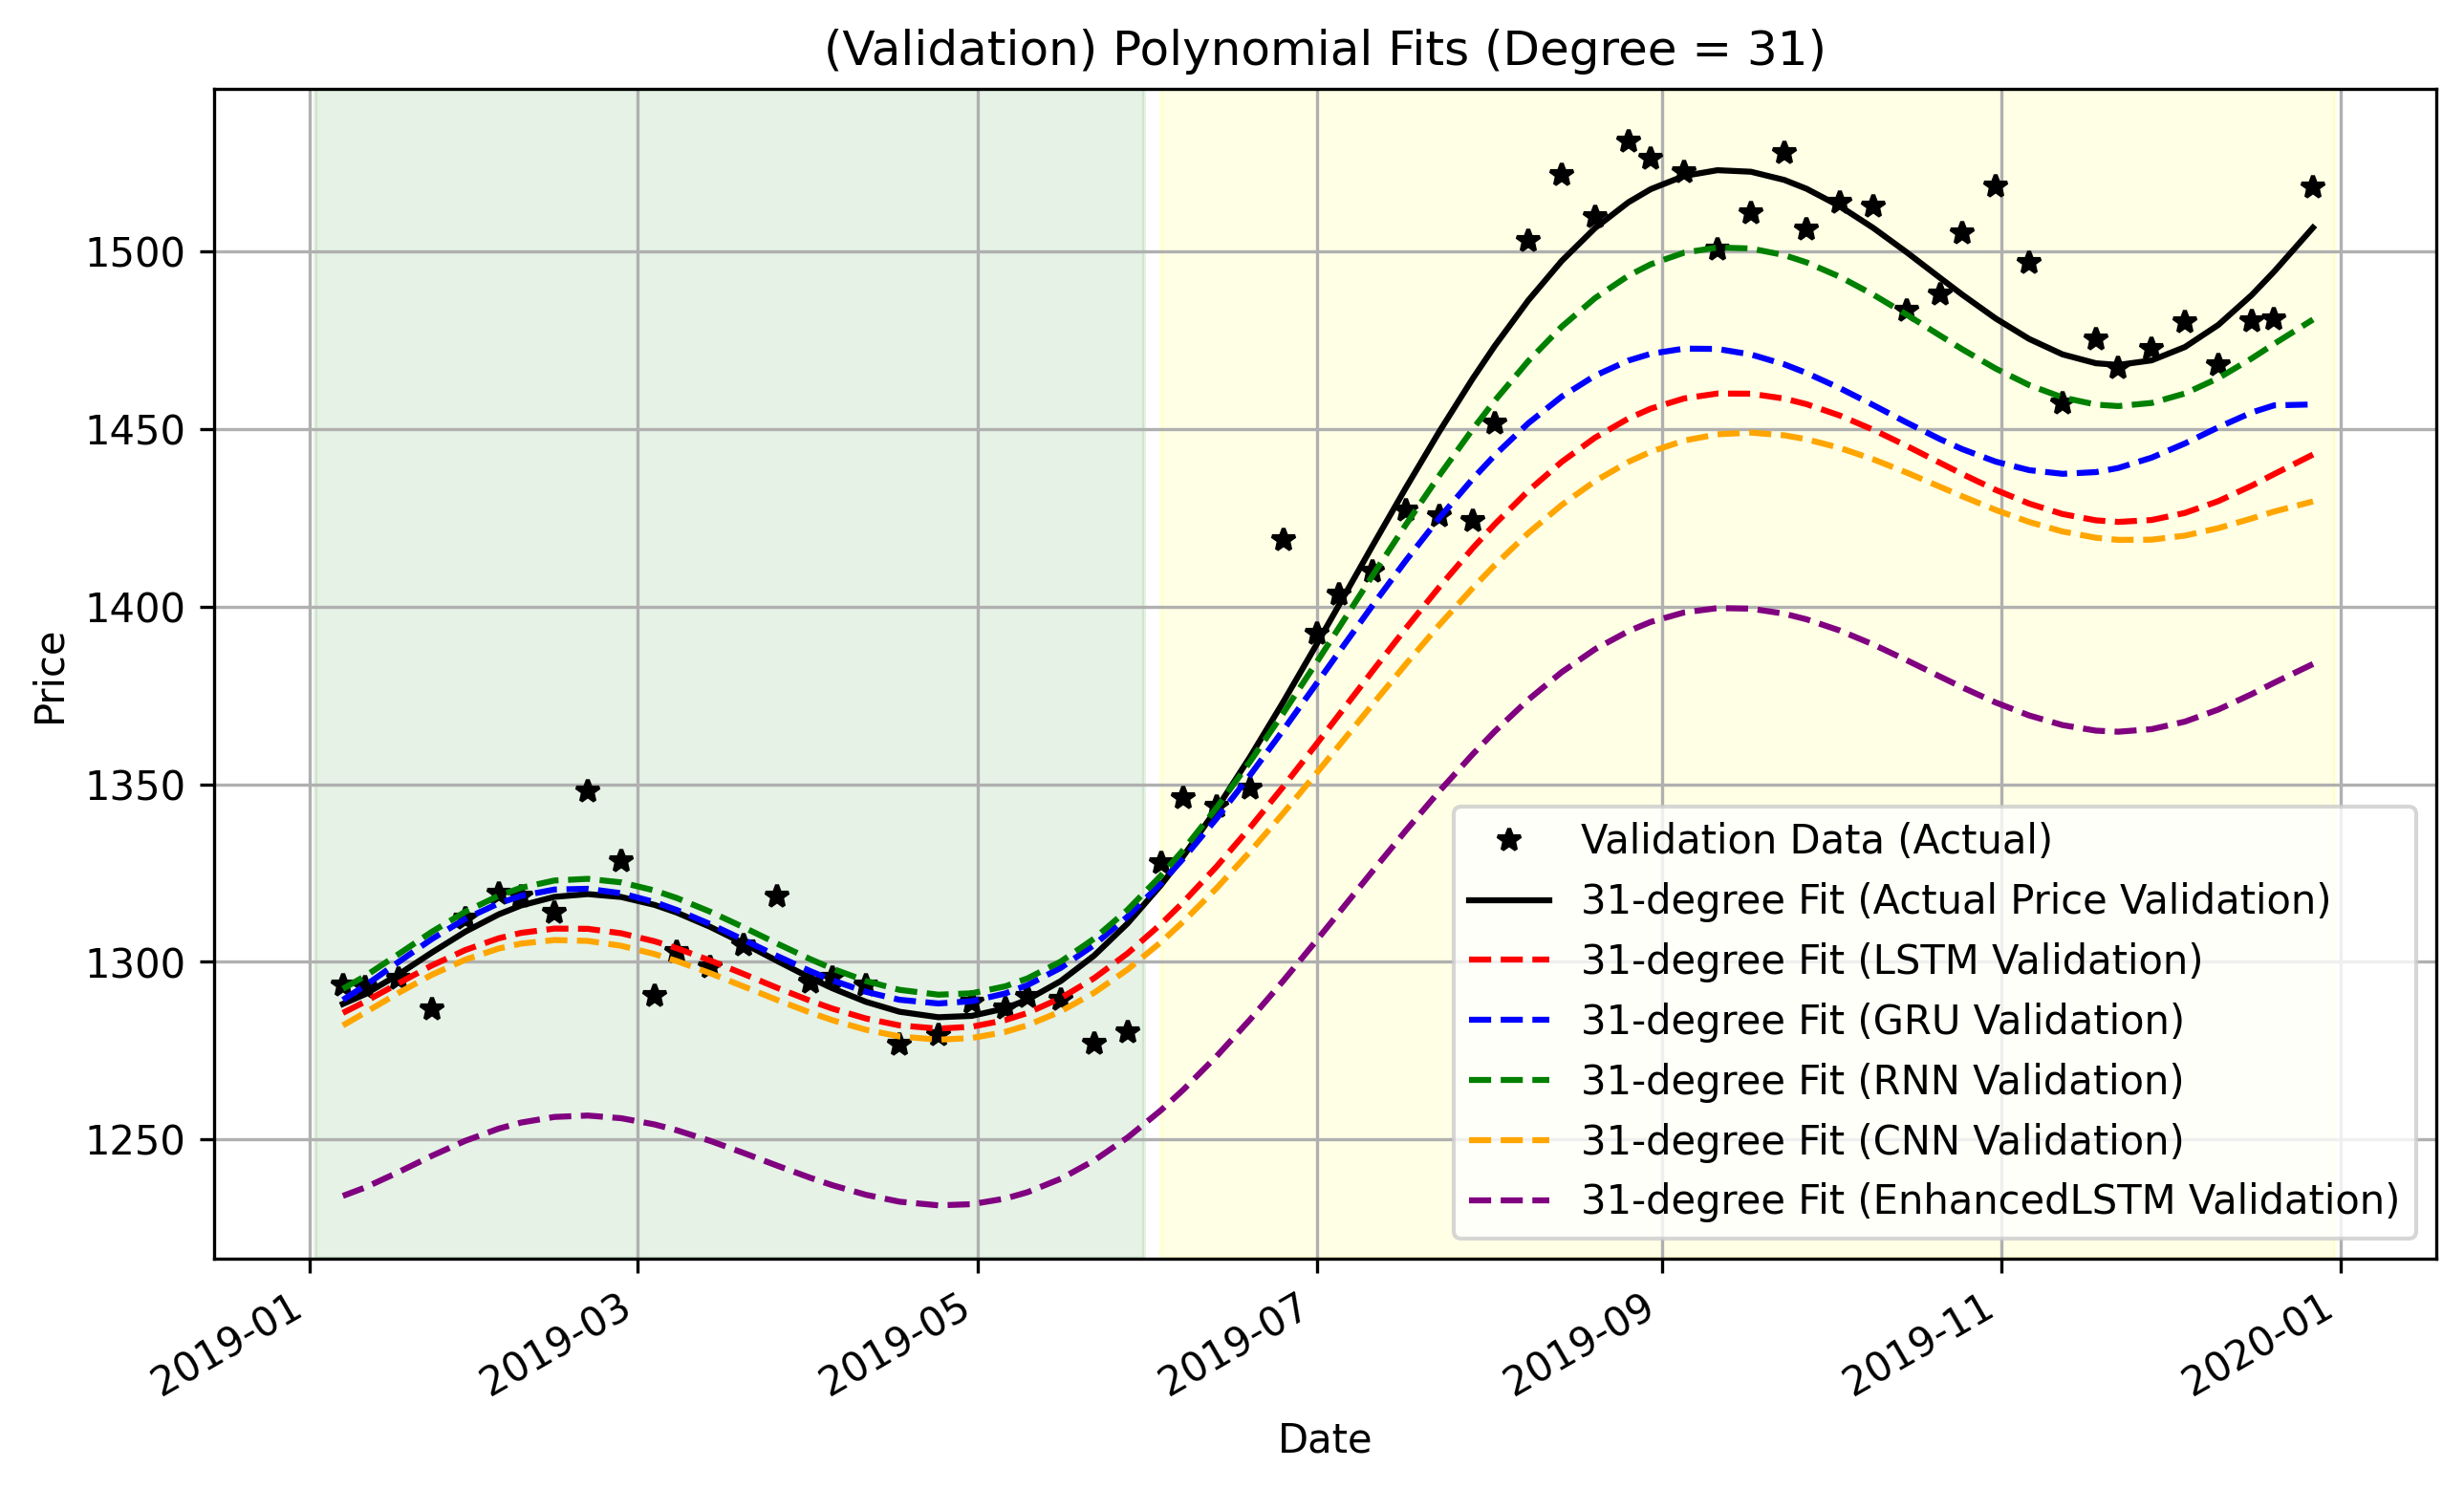

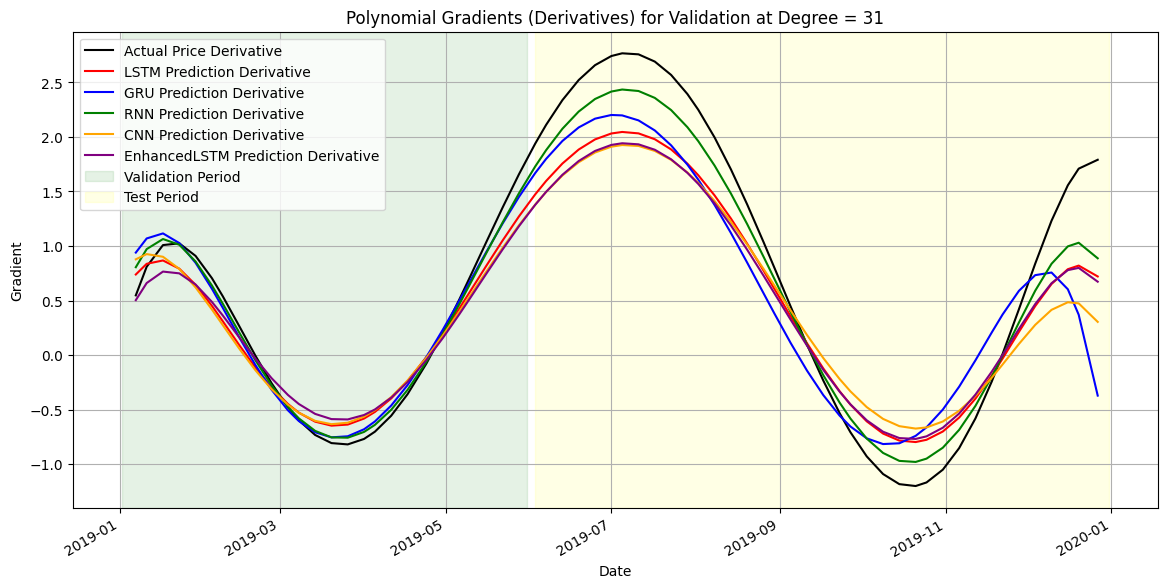


Derivative Polynomial Expressions (Degree = 30) at n = 31:
------------------------------------------------------------
Actual Price Derivative: -2.564298e-118*x^30+3.583606e-114*x^29+7.757198e-110*x^28+6.658539e-106*x^27-3.547302e-102*x^26-2.560513e-97*x^25-5.785627e-93*x^24-8.905186e-89*x^23-9.120519e-85*x^22-1.341485e-81*x^21+2.174339e-76*x^20+6.790201e-72*x^19+1.399963e-67*x^18+2.241538e-63*x^17+2.717385e-59*x^16+1.725650e-55*x^15-2.630839e-51*x^14-1.286662e-46*x^13-3.111872e-42*x^12-5.636564e-38*x^11-7.918830e-34*x^10-7.409891e-30*x^9+6.341444e-27*x^8+2.238534e-21*x^7+6.158430e-17*x^6+1.093385e-12*x^5+1.289249e-08*x^4+4.905433e-05*x^3-1.920221e+00*x^2-4.828636e+04*x^1-3.576157e+08
LSTM Derivative: -1.799071e-118*x^30+2.512275e-114*x^29+5.440952e-110*x^28+4.674762e-106*x^27-2.476150e-102*x^26-1.793960e-97*x^25-4.055966e-93*x^24-6.246117e-89*x^23-6.403762e-85*x^22-9.614971e-82*x^21+1.520716e-76*x^20+4.755338e-72*x^19+9.809848e-68*x^18+1.571483e-63*x^17+1.906593e-59*x^16+1.214603e-5

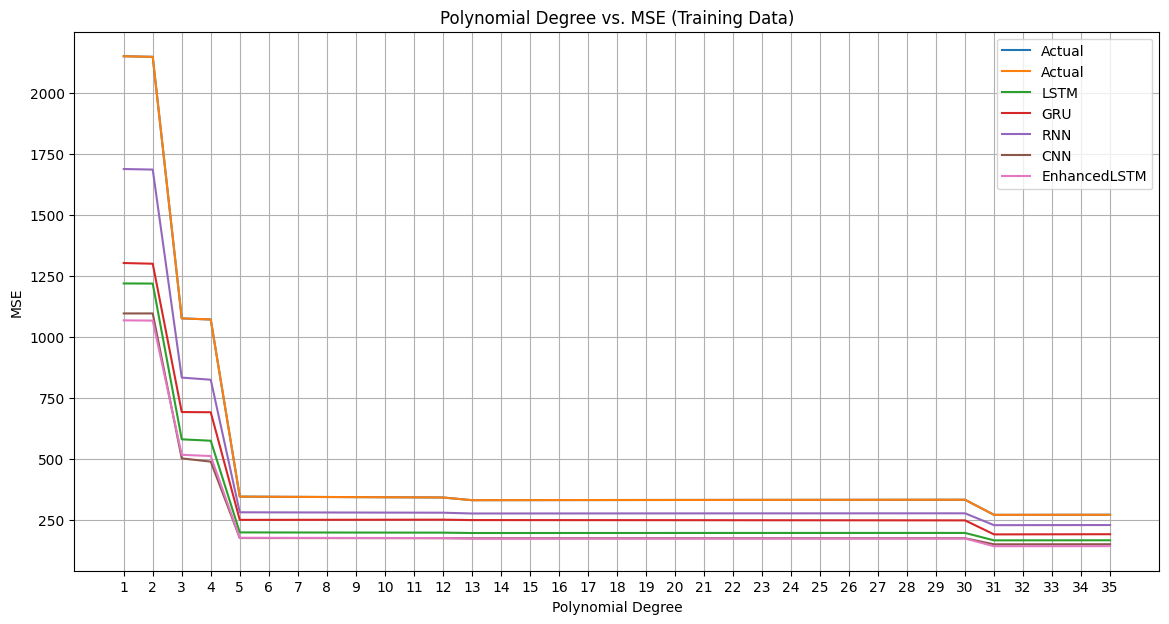

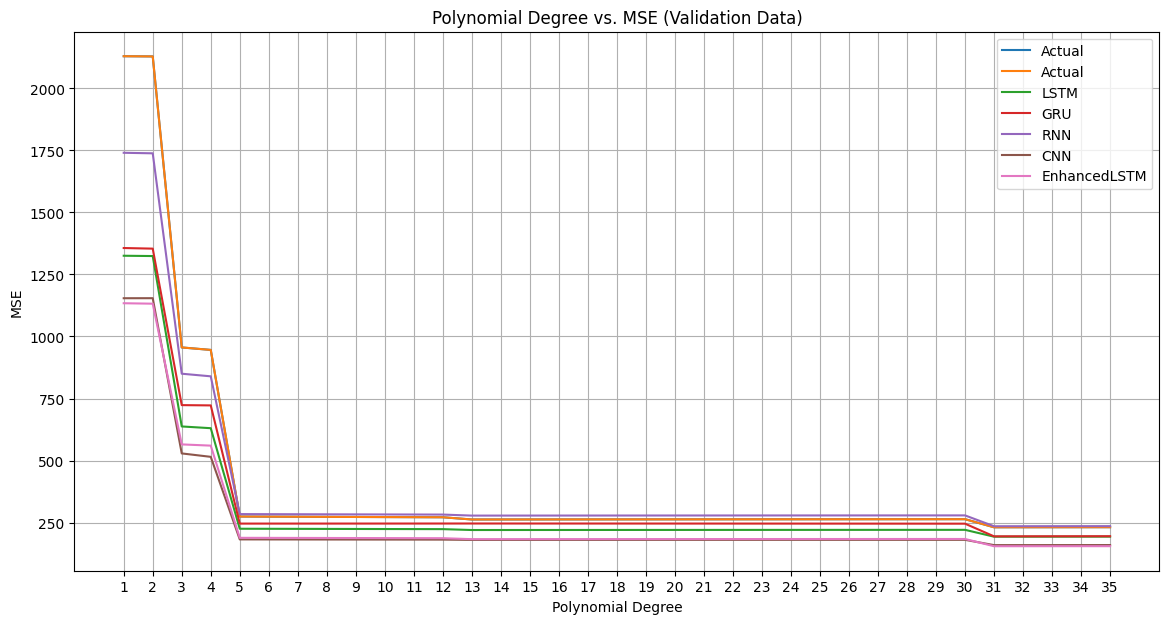

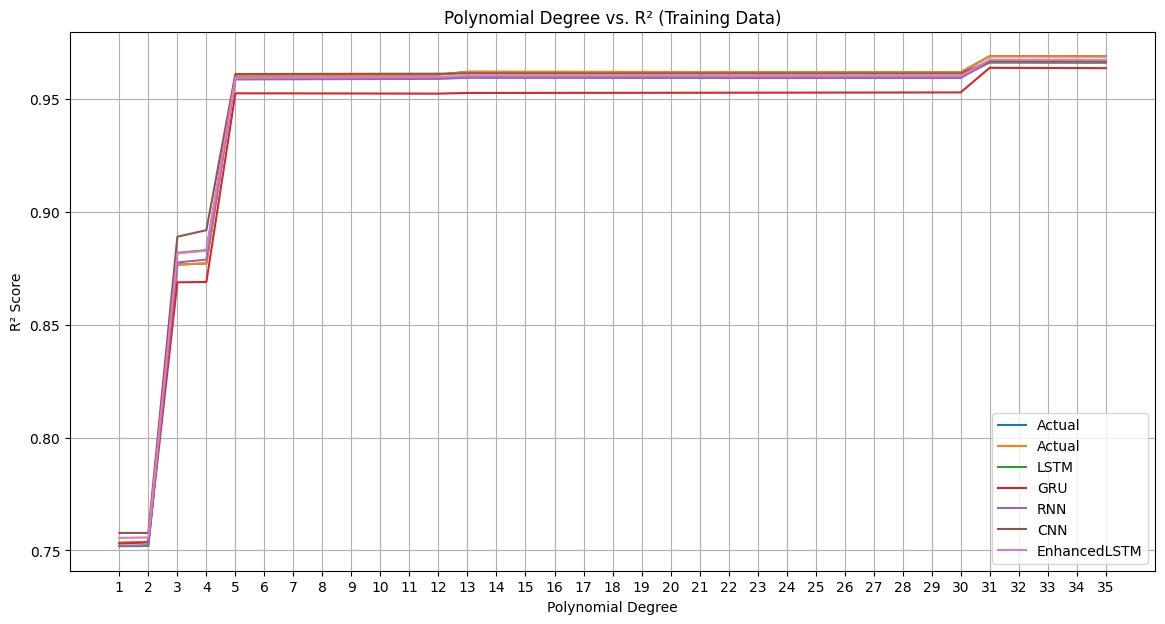

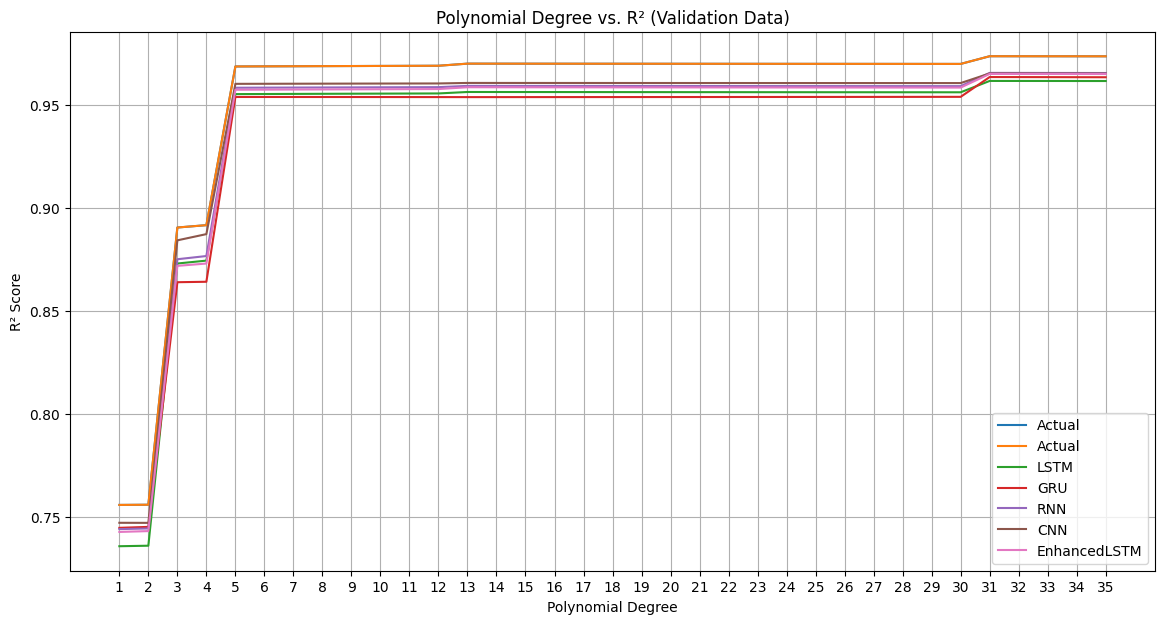

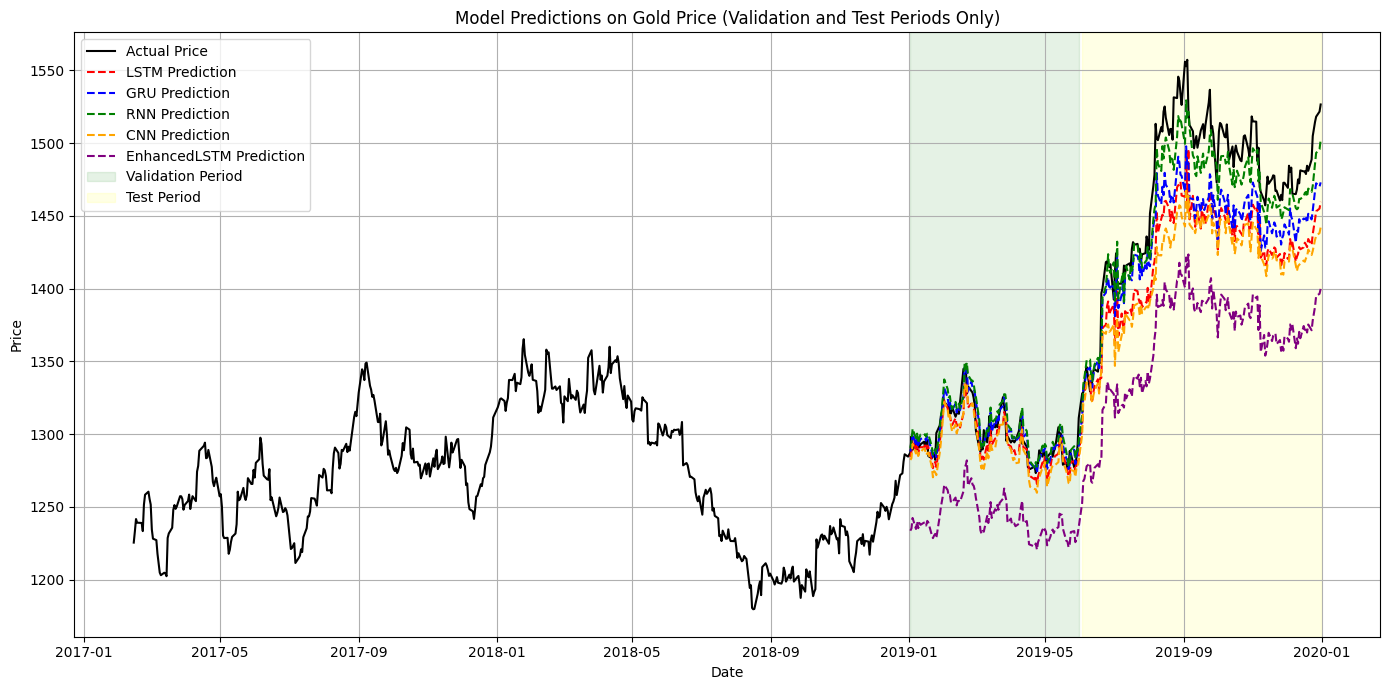


===== ONE-QUARTER VALIDATION: Piecewise Conservative Strategy =====
Total trades: 5
Final P&L: 429.70
Long days: 151, Short days: 88, Flat days: 19

===== ONE-QUARTER VALIDATION: Piecewise Optimistic Strategy =====
Total trades: 5
Final P&L: 437.20
Long days: 170, Short days: 88, Flat days: 0


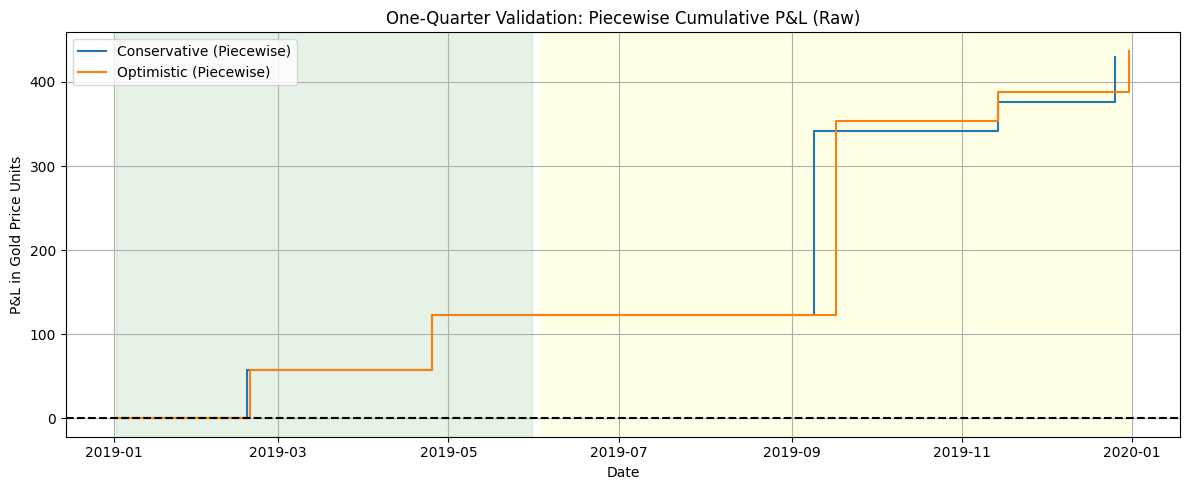

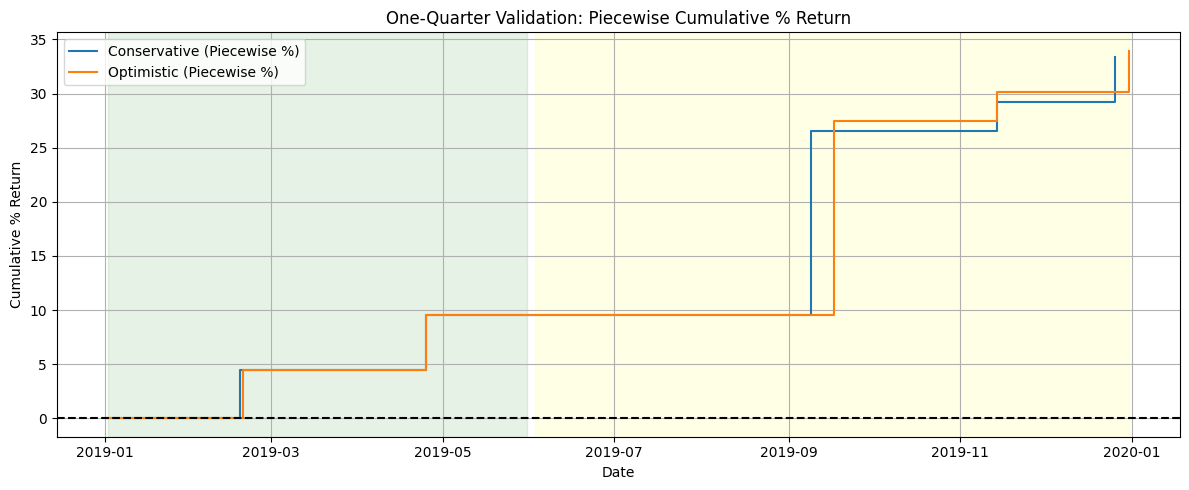

In [5]:
##############################################################################
# 1) Imports and Setup
##############################################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    mean_absolute_percentage_error, 
    mean_squared_error, 
    r2_score
)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import warnings
import matplotlib.dates as mdates

warnings.filterwarnings("ignore")  # Hide any warnings for cleaner output

# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

##############################################################################
# 2) Load and Prepare Data
##############################################################################
df = pd.read_csv('Gold Price_Year 2017-2019.csv')
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

num_cols = df.columns.drop(['Date'])
df[num_cols] = df[num_cols].replace({',': ''}, regex=True)
df[num_cols] = df[num_cols].astype('float64')

assert df.duplicated().sum() == 0, "Duplicate rows found!"
assert df.isnull().sum().sum() == 0, "Missing values found!"

features = ['Price', 'Open', 'High', 'Low']
data = df[features].values

# Scale data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Create sequences
window_width = 30
X, y, dates = [], [], []
for i in range(window_width, len(data_scaled)):
    X.append(data_scaled[i - window_width : i])
    y.append(data_scaled[i, 0])  # Price as target
    dates.append(df['Date'].iloc[i])

X = np.array(X)
y = np.array(y)
dates = np.array(dates)

# Train/Val/Test masks
train_mask = (
    (dates >= pd.to_datetime('2017-01-03')) &
    (dates <= pd.to_datetime('2018-12-31'))
)
val_mask = (
    (dates >= pd.to_datetime('2019-01-02')) &
    (dates <= pd.to_datetime('2019-05-31'))
)
test_mask = (
    (dates >= pd.to_datetime('2019-06-03')) &
    (dates <= pd.to_datetime('2019-12-31'))
)

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

train_dates = dates[train_mask]
val_dates = dates[val_mask]
test_dates = dates[test_mask]

# Convert to tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1)
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).float().unsqueeze(1)
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##############################################################################
# 3) Define Model
##############################################################################
class BaseModel(nn.Module):
    def __init__(self, model_type='LSTM', hidden_size=128, num_layers=2, dropout=0.1, lr=0.0005):
        super(BaseModel, self).__init__()
        self.model_type = model_type
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.lr = lr
        
        if model_type == 'LSTM':
            self.rnn = nn.LSTM(
                input_size=len(features),
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True,
                dropout=dropout,
            )
            self.fc = nn.Linear(hidden_size, 1)
        elif model_type == 'GRU':
            self.rnn = nn.GRU(
                input_size=len(features),
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True,
                dropout=dropout,
            )
            self.fc = nn.Linear(hidden_size, 1)
        elif model_type == 'RNN':
            self.rnn = nn.RNN(
                input_size=len(features),
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True,
                nonlinearity='relu',
                dropout=dropout,
            )
            self.fc = nn.Linear(hidden_size, 1)
        elif model_type == 'CNN':
            self.conv1 = nn.Conv1d(in_channels=len(features), out_channels=64, kernel_size=3)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
            conv_output_length = window_width - 2 * (3 - 1)
            self.fc = nn.Linear(128 * conv_output_length, 1)
        elif model_type == 'EnhancedLSTM':
            self.rnn = nn.LSTM(
                input_size=len(features),
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True,
                dropout=dropout
            )
            self.bn = nn.BatchNorm1d(hidden_size)
            self.dropout_layer = nn.Dropout(dropout)
            self.fc = nn.Linear(hidden_size, 1)
        else:
            raise ValueError("Invalid model_type.")

    def forward(self, x):
        if self.model_type == 'CNN':
            x = x.permute(0, 2, 1)  # (batch, channels, seq_len)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            out = self.fc(x)
        elif self.model_type == 'EnhancedLSTM':
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.bn(out)
            out = self.dropout_layer(out)
            out = self.fc(out)
        else:
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.fc(out)
        return out

##############################################################################
# 4) Utilities
##############################################################################
class EarlyStopping:
    def __init__(self, patience=150, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def inverse_transform(y_scaled):
    """Inverse transform the 'Price' from scaled to original domain."""
    y_scaled = np.array(y_scaled).reshape(-1, 1)
    zeros = np.zeros((y_scaled.shape[0], len(features) - 1))
    y_combined = np.hstack((y_scaled, zeros))
    y_inv = scaler.inverse_transform(y_combined)
    return y_inv[:, 0]

def evaluate_on_validation(model, val_loader, criterion):
    model.eval()
    val_losses = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_losses.append(loss.item())
    return np.mean(val_losses)

def train_model(model, train_loader, val_loader, num_epochs=1000, patience=150):
    criterion = nn.HuberLoss()
    optimizer = optim.AdamW(model.parameters(), lr=model.lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=patience)
    early_stopping = EarlyStopping(patience=patience, min_delta=0)

    best_val_loss = float('inf')
    train_losses, val_losses = [], []
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        batch_losses = []
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        
        avg_train_loss = np.mean(batch_losses)
        train_losses.append(avg_train_loss)

        # Validation
        avg_val_loss = evaluate_on_validation(model, val_loader, criterion)
        val_losses.append(avg_val_loss)
        
        scheduler.step(avg_val_loss)
        early_stopping(avg_val_loss)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
        
        if early_stopping.early_stop:
            break

    # Restore best weights
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return best_val_loss, train_losses, val_losses

##############################################################################
# 5) Hyper-Parameter Search
##############################################################################
def hyperparameter_search(model_type, train_loader, val_loader):
    hidden_sizes = [64, 128]
    dropouts = [0.1, 0.2]
    lrs = [0.0005, 0.001]
    num_layers_list = [2, 3]

    best_combination = None
    best_val_loss = float('inf')
    best_train_losses = []
    best_val_losses = []

    for hidden_size in hidden_sizes:
        for dropout in dropouts:
            for lr in lrs:
                for num_layers in num_layers_list:
                    model = BaseModel(
                        model_type=model_type,
                        hidden_size=hidden_size,
                        dropout=dropout,
                        lr=lr,
                        num_layers=num_layers
                    ).to(device)

                    print(f"\n[HP-Search] {model_type} | hidden={hidden_size}, drop={dropout}, lr={lr}, layers={num_layers}")
                    val_loss, train_hist, val_hist = train_model(
                        model, train_loader, val_loader, num_epochs=300, patience=50
                    )
                    
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        best_combination = {
                            'hidden_size': hidden_size,
                            'dropout': dropout,
                            'lr': lr,
                            'num_layers': num_layers,
                        }
                        best_train_losses = train_hist
                        best_val_losses = val_hist

    print(f"\n[HP-Search] Best combination for {model_type}: {best_combination} with val_loss={best_val_loss:.6f}")
    return best_combination, best_train_losses, best_val_losses

##############################################################################
# 6) Load or Train (Skipping Re-Training If File Exists)
##############################################################################
def get_model_outputs(model_type, force_train=False):
    """
    1) Checks 'extended_prediction_best_model_<model_type>.pt'.
       - If file exists and force_train=False, load the file directly.
       - Otherwise, hyper-param search + train + save file.
    2) Returns dictionary with predictions, best_params, etc.
    """
    extended_pred_path = f'extended_prediction_best_model_{model_type}.pt'
    
    if (not force_train) and os.path.exists(extended_pred_path):
        print(f"\n[INFO] Found existing {extended_pred_path}. Loading without re-training...")
        loaded_data = torch.load(extended_pred_path, map_location=device)
        
        best_params = loaded_data['best_params']
        y_val_pred_inv = loaded_data['y_val_pred_inv']
        y_test_pred_inv = loaded_data['y_test_pred_inv']
        train_losses_per_epoch = loaded_data['train_losses_per_epoch']
        val_losses_per_epoch = loaded_data['val_losses_per_epoch']
        
        # Reconstruct the best model if needed
        best_model = BaseModel(
            model_type=model_type,
            hidden_size=best_params['hidden_size'],
            dropout=best_params['dropout'],
            lr=best_params['lr'],
            num_layers=best_params['num_layers']
        ).to(device)
        best_model.load_state_dict(loaded_data['state_dict'])
        best_model.eval()

    else:
        print(f"\n[INFO] No file or force_train=True. Searching hyper-params for {model_type}...")
        best_params, _, _ = hyperparameter_search(model_type, train_loader, val_loader)
        
        best_model = BaseModel(
            model_type=model_type,
            hidden_size=best_params['hidden_size'],
            dropout=best_params['dropout'],
            lr=best_params['lr'],
            num_layers=best_params['num_layers']
        ).to(device)

        print(f"\nRetraining {model_type} with best hyperparams: {best_params}")
        _, train_losses_per_epoch, val_losses_per_epoch = train_model(
            best_model, train_loader, val_loader, num_epochs=800, patience=150
        )

        # Inference on test
        criterion = nn.HuberLoss()
        best_model.eval()
        test_losses = []
        y_test_pred_list = []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = best_model(X_batch)
                loss = criterion(y_pred, y_batch)
                test_losses.append(loss.item())
                y_test_pred_list.append(y_pred.cpu().numpy())

        y_test_pred_array = np.concatenate(y_test_pred_list, axis=0)
        # Validation predictions
        y_val_pred_list = []
        with torch.no_grad():
            for X_batch, _ in val_loader:
                X_batch = X_batch.to(device)
                y_val_pred_list.append(best_model(X_batch).cpu().numpy())
        y_val_pred = np.concatenate(y_val_pred_list, axis=0)

        y_val_pred_inv = inverse_transform(y_val_pred)
        y_test_pred_inv = inverse_transform(y_test_pred_array)

        # Save
        save_dict = {
            'state_dict': best_model.state_dict(),
            'best_params': best_params,
            'y_val_pred_inv': y_val_pred_inv,
            'y_test_pred_inv': y_test_pred_inv,
            'train_losses_per_epoch': train_losses_per_epoch,
            'val_losses_per_epoch': val_losses_per_epoch,
        }
        torch.save(save_dict, extended_pred_path)
        print(f"[INFO] Saved best {model_type} model + predictions to {extended_pred_path}")

    # Compute final test metrics in original scale
    # (We have y_test_inv from global scope, or we can handle it outside)
    # We'll just store them here if needed outside
    results = {
        'model_name': model_type,
        'best_params': best_params,
        'y_val_pred_inv': y_val_pred_inv,
        'y_test_pred_inv': y_test_pred_inv,
        'train_losses_per_epoch': train_losses_per_epoch,
        'val_losses_per_epoch': val_losses_per_epoch,
        'best_model': best_model,  # If we need the actual model
    }
    return results

##############################################################################
# 7) Main Flow: Gather Each Model's Output & Print Test Metrics
##############################################################################
model_names = ['LSTM', 'GRU', 'RNN', 'CNN', 'EnhancedLSTM']
all_results = {}

# We'll need the unscaled "y_test_inv" to compute metrics
y_test_inv = inverse_transform(y_test_tensor.numpy())

for mname in model_names:
    print(f"\n\n>>> Handling {mname} Model <<<")
    results = get_model_outputs(mname, force_train=False)
    all_results[mname] = results

    # Compute test metrics from loaded predictions
    y_test_pred_inv = results['y_test_pred_inv']
    
    # 1) Huber Loss in original scale
    huber_criterion = nn.HuberLoss()
    # Convert arrays to torch tensors for the loss
    test_loss_val = huber_criterion(
        torch.from_numpy(y_test_pred_inv).float(),
        torch.from_numpy(y_test_inv).float()
    ).item()
    
    # 2) MAPE
    test_mape = mean_absolute_percentage_error(y_test_inv, y_test_pred_inv)
    # 3) Accuracy
    test_accuracy = 100 - test_mape * 100
    # 4) Test MSE
    test_mse = mean_squared_error(y_test_inv, y_test_pred_inv)

    print(f"{mname} -> Test Loss (Huber): {test_loss_val:.6f}")
    print(f"{mname} -> Test MAPE:        {test_mape * 100:.2f}%")
    print(f"{mname} -> Test Accuracy:    {test_accuracy:.2f}%")
    print(f"{mname} -> Test MSE:         {test_mse:.6f}")

##############################################################################
# 8) Zoomed-in Plot of Predictions on Validation + Test
##############################################################################
model_colors = {
    'LSTM': 'red',
    'GRU': 'blue',
    'RNN': 'green',
    'CNN': 'orange',
    'EnhancedLSTM': 'purple',
}

# We'll also need the unscaled "y_val_inv"
y_val_inv = inverse_transform(y_val_tensor.numpy())

plt.figure(figsize=(14, 7))
zoom_dates = np.concatenate((val_dates, test_dates))
zoom_actual = np.concatenate((y_val_inv, y_test_inv))

# Plot actual
plt.plot(zoom_dates, zoom_actual, color='black', label='Actual Price')

# Plot predictions
for model_name, results in all_results.items():
    y_pred_combined = np.concatenate((results['y_val_pred_inv'], results['y_test_pred_inv']))
    model_dates = np.concatenate((val_dates, test_dates))
    plt.plot(model_dates, y_pred_combined, color=model_colors[model_name], linestyle='--',
             label=f'{model_name} Prediction')

# Highlight validation and test periods
plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')

plt.title('Zoomed-in Model Predictions on Gold Price (Validation + Test)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##############################################################################
# 9) Polynomial Fitting & Gradient Calculations at Degree = 29
##############################################################################
# You can reuse the exact polynomial-fitting code from before.
# Here's a concise version focusing on the final "n=29" scenario
# and printing expressions for Actual + each model in order.

# Combine val+test
zoom_dates = np.concatenate((val_dates, test_dates))
zoom_actual = np.concatenate((y_val_inv, y_test_inv))
date_numeric = mdates.date2num(zoom_dates)

# Replace the old "even vs odd" day partition with a "3 training days + 1 validation day" scheme
training_mask = np.array([(i % 4) != 3 for i in range(len(zoom_dates))])
validation_mask = ~training_mask

zoom_dates_train = zoom_dates[training_mask]
zoom_actual_train = zoom_actual[training_mask]
date_numeric_train = date_numeric[training_mask]

zoom_dates_val = zoom_dates[validation_mask]
zoom_actual_val = zoom_actual[validation_mask]
date_numeric_val = date_numeric[validation_mask]

model_names_for_poly = ['Actual', 'LSTM', 'GRU', 'RNN', 'CNN', 'EnhancedLSTM']
models_plus_actual = ['Actual'] + model_names_for_poly

def format_polynomial(coeffs):
    terms = []
    degree = len(coeffs) - 1
    for i, coef in enumerate(coeffs):
        current_degree = degree - i
        if current_degree > 0:
            terms.append(f"{coef:+.6e}*x^{current_degree}")
        else:
            terms.append(f"{coef:+.6e}")
    return "".join(terms).replace("+-", "-")

def format_polynomial_derivative(coeffs):
    terms = []
    degree = len(coeffs) - 1
    for i, coef in enumerate(coeffs):
        current_degree = degree - i
        if current_degree > 0:
            terms.append(f"{coef:+.6e}*x^{current_degree}")
        else:
            terms.append(f"{coef:+.6e}")
    return "".join(terms).replace("+-", "-")


# Define the range of polynomial degrees to evaluate
poly_degrees = range(1, 70)  # Degrees from 1 to 69

# Initialize variables to track the best validation MSE and R²
lowest_val_mse = float('inf')
highest_val_r2 = float('-inf')

best_val_mse_info = None
best_val_r2_info = None

# -------------------------------------------------
# 1) Find degrees for the lowest Validation MSE
#    and the highest Validation R²
# -------------------------------------------------
for n in poly_degrees:
    # Fit polynomial to ACTUAL (training) -> Evaluate on validation
    coeff_actual_train = np.polyfit(date_numeric_train, zoom_actual_train, n)
    poly_actual_val = np.polyval(coeff_actual_train, date_numeric_val)
    val_mse_actual = mean_squared_error(zoom_actual_val, poly_actual_val)
    val_r2_actual  = r2_score(zoom_actual_val, poly_actual_val)

    # Check if Actual's validation MSE / R² are best
    if val_mse_actual < lowest_val_mse:
        lowest_val_mse = val_mse_actual
        best_val_mse_info = ("Actual", n, val_mse_actual)

    if val_r2_actual > highest_val_r2:
        highest_val_r2 = val_r2_actual
        best_val_r2_info = ("Actual", n, val_r2_actual)

    # Fit polynomial for each model; check validation MSE / R²
    for model_name in model_names:
        y_pred_combined = np.concatenate((
            all_results[model_name]['y_val_pred_inv'],
            all_results[model_name]['y_test_pred_inv']
        ))
        y_pred_train = y_pred_combined[training_mask]
        y_pred_val   = y_pred_combined[validation_mask]

        model_coeff_train = np.polyfit(date_numeric_train, y_pred_train, n)
        model_poly_val    = np.polyval(model_coeff_train, date_numeric_val)
        val_mse_model     = mean_squared_error(y_pred_val, model_poly_val)
        val_r2_model      = r2_score(y_pred_val, model_poly_val)

        if val_mse_model < lowest_val_mse:
            lowest_val_mse = val_mse_model
            best_val_mse_info = (model_name, n, val_mse_model)

        if val_r2_model > highest_val_r2:
            highest_val_r2 = val_r2_model
            best_val_r2_info = (model_name, n, val_r2_model)

print("Lowest Validation MSE ->", best_val_mse_info)
print("Highest Validation R²   ->", best_val_r2_info)

# -------------------------------------------------
# 2) Plot only those degrees (maybe 1 or 2 if distinct)
# -------------------------------------------------
if best_val_mse_info and best_val_r2_info:
    degrees_to_plot = set([best_val_mse_info[1], best_val_r2_info[1]])  # { degreeForMse, degreeForR2 }

    for n in degrees_to_plot:
        # ----------------
        # Plot Training
        # ----------------
        plt.figure(figsize=(10,6), dpi=300)
        # Actual
        plt.plot(zoom_dates_train, zoom_actual_train, 'k*', label='Training Data (Actual)')
        coeff_actual_train = np.polyfit(date_numeric_train, zoom_actual_train, n)
        poly_actual_train = np.polyval(coeff_actual_train, date_numeric_train)
        plt.plot(zoom_dates_train, poly_actual_train, color='black',
                 label=f'{n}-degree Fit (Actual Price Training)')

        # Each model
        for model_name in model_names:
            y_pred_combined = np.concatenate((
                all_results[model_name]['y_val_pred_inv'],
                all_results[model_name]['y_test_pred_inv']
            ))
            y_pred_train = y_pred_combined[training_mask]
            coeff_pred_train = np.polyfit(date_numeric_train, y_pred_train, n)
            poly_pred_train = np.polyval(coeff_pred_train, date_numeric_train)
            plt.plot(zoom_dates_train, poly_pred_train,
                     color=model_colors[model_name],
                     linestyle='--',
                     label=f'{n}-degree Fit ({model_name} Training)')

        plt.title(f'(Training) Polynomial Fits (Degree = {n})')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.grid(True)
        plt.legend(loc='best')
        plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
        plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')
        plt.gcf().autofmt_xdate()
        plt.show()

        # ----------------
        # Plot Validation
        # ----------------
        plt.figure(figsize=(10,6),dpi=300)
        # Actual
        plt.plot(zoom_dates_val, zoom_actual_val, 'k*', label='Validation Data (Actual)')
        poly_actual_val = np.polyval(coeff_actual_train, date_numeric_val)
        plt.plot(zoom_dates_val, poly_actual_val, color='black',
                 label=f'{n}-degree Fit (Actual Price Validation)')

        # Each model
        for model_name in model_names:
            y_pred_combined = np.concatenate((
                all_results[model_name]['y_val_pred_inv'],
                all_results[model_name]['y_test_pred_inv']
            ))
            y_pred_train = y_pred_combined[training_mask]
            coeff_pred_train = np.polyfit(date_numeric_train, y_pred_train, n)
            poly_pred_val = np.polyval(coeff_pred_train, date_numeric_val)
            plt.plot(zoom_dates_val, poly_pred_val,
                     color=model_colors[model_name],
                     linestyle='--',
                     label=f'{n}-degree Fit ({model_name} Validation)')

        plt.title(f'(Validation) Polynomial Fits (Degree = {n})')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.grid(True)
        plt.legend(loc='best')
        plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
        plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')
        plt.gcf().autofmt_xdate()
        plt.show()


# -------------------------------------------------
# 5) Plot polynomial gradients (derivatives) for Validation Data at Degree = 29
#    and print their mathematical expressions.
# -------------------------------------------------

plt.figure(figsize=(14, 7))
deriv_coeff_actual = np.polyder(coeff_actual_train)
val_deriv_actual = np.polyval(deriv_coeff_actual, date_numeric_val)
plt.plot(zoom_dates_val, val_deriv_actual, 'k-', label='Actual Price Derivative')

for model_name in model_names_for_poly[1:]:
    y_pred_combined = np.concatenate((
        all_results[model_name]['y_val_pred_inv'],
        all_results[model_name]['y_test_pred_inv']
    ))
    y_pred_train = y_pred_combined[training_mask]
    coeff_model_train = np.polyfit(date_numeric_train, y_pred_train, n)
    deriv_coeff_model = np.polyder(coeff_model_train)
    val_deriv_model = np.polyval(deriv_coeff_model, date_numeric_val)
    plt.plot(zoom_dates_val, val_deriv_model, color=model_colors[model_name], label=f'{model_name} Prediction Derivative')

plt.title(f'Polynomial Gradients (Derivatives) for Validation at Degree = {n}')
plt.xlabel('Date')
plt.ylabel('Gradient')
plt.grid(True)
plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')
plt.legend(loc='best')
plt.gcf().autofmt_xdate()
plt.show()

# 9.3) Print derivative polynomial expressions
print(f"\nDerivative Polynomial Expressions (Degree = {n - 1}) at n = {n}:")
print("-"*60)
print("Actual Price Derivative:", format_polynomial_derivative(deriv_coeff_actual))

for model_name in model_names_for_poly[1:]:
    y_pred_combined = np.concatenate((
        all_results[model_name]['y_val_pred_inv'],
        all_results[model_name]['y_test_pred_inv']
    ))
    y_pred_train = y_pred_combined[training_mask]
    coeff_model_train = np.polyfit(date_numeric_train, y_pred_train, n)
    deriv_coeff_model = np.polyder(coeff_model_train)
    expr_deriv = format_polynomial_derivative(deriv_coeff_model)
    print(f"{model_name} Derivative: {expr_deriv}")

##############################################################################
# 9.4) (Appended) Plot MSE/R² vs Polynomial Degree (focusing up to 20)
##############################################################################
plot_max_degree = 35
degrees_arr = np.arange(1, plot_max_degree + 1)

train_mse_dict = {m: np.zeros(plot_max_degree) for m in models_plus_actual}
val_mse_dict   = {m: np.zeros(plot_max_degree) for m in models_plus_actual}
train_r2_dict  = {m: np.zeros(plot_max_degree) for m in models_plus_actual}
val_r2_dict    = {m: np.zeros(plot_max_degree) for m in models_plus_actual}

for n in range(1, plot_max_degree + 1):
    for mname in models_plus_actual:
        if mname == 'Actual':
            y_data_train = zoom_actual_train
            y_data_val   = zoom_actual_val
        else:
            y_pred_combined = np.concatenate((all_results[mname]['y_val_pred_inv'],
                                              all_results[mname]['y_test_pred_inv']))
            y_pred_train = y_pred_combined[training_mask]
            y_data_train = y_pred_train
            y_data_val   = y_pred_combined[validation_mask]

        coeffs = np.polyfit(date_numeric_train, y_data_train, n)
        yhat_train = np.polyval(coeffs, date_numeric_train)
        train_mse_dict[mname][n - 1] = mean_squared_error(y_data_train, yhat_train)
        train_r2_dict[mname][n - 1]  = r2_score(y_data_train, yhat_train)

        yhat_val = np.polyval(coeffs, date_numeric_val)
        val_mse_dict[mname][n - 1] = mean_squared_error(y_data_val, yhat_val)
        val_r2_dict[mname][n - 1]  = r2_score(y_data_val, yhat_val)

def set_focused_ylim(data_dict, buffer_ratio=0.05):
    flattened = []
    for arr in data_dict.values():
        flattened.extend(arr)
    min_val, max_val = min(flattened), max(flattened)
    buffer = (max_val - min_val) * buffer_ratio
    return min_val - buffer, max_val + buffer

# Plot MSE - Training
plt.figure(figsize=(14, 7))
plt.title("Polynomial Degree vs. MSE (Training Data)")
for m in models_plus_actual:
    plt.plot(degrees_arr, train_mse_dict[m], label=str(m))
plt.xlabel("Polynomial Degree")
plt.ylabel("MSE")
plt.xticks(degrees_arr)
plt.legend(loc='best')
plt.grid(True)
ymin, ymax = set_focused_ylim(train_mse_dict)
plt.ylim(ymin, ymax)
plt.show()

# Plot MSE - Validation
plt.figure(figsize=(14, 7))
plt.title("Polynomial Degree vs. MSE (Validation Data)")
for m in models_plus_actual:
    plt.plot(degrees_arr, val_mse_dict[m], label=str(m))
plt.xlabel("Polynomial Degree")
plt.ylabel("MSE")
plt.xticks(degrees_arr)
plt.legend(loc='best')
plt.grid(True)
ymin, ymax = set_focused_ylim(val_mse_dict)
plt.ylim(ymin, ymax)
plt.show()

# Plot R² - Training
plt.figure(figsize=(14, 7))
plt.title("Polynomial Degree vs. R² (Training Data)")
for m in models_plus_actual:
    plt.plot(degrees_arr, train_r2_dict[m], label=str(m))
plt.xlabel("Polynomial Degree")
plt.ylabel("R² Score")
plt.xticks(degrees_arr)
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Plot R² - Validation
plt.figure(figsize=(14, 7))
plt.title("Polynomial Degree vs. R² (Validation Data)")
for m in models_plus_actual:
    plt.plot(degrees_arr, val_r2_dict[m], label=str(m))
plt.xlabel("Polynomial Degree")
plt.ylabel("R² Score")
plt.xticks(degrees_arr)
plt.legend(loc='best')
plt.grid(True)
plt.show()


##############################################################################
# 9.6) (Appended) Model Predictions on Gold Price Overview (2017-2019)
##############################################################################
# Plotting the full dataset with predictions over validation and test sets only
plt.figure(figsize=(14, 7))

# Actual Price
plt.plot(dates, inverse_transform(y), color='black', label='Actual Price')

for model_name, results in all_results.items():
    y_pred_combined = np.concatenate((results['y_val_pred_inv'], results['y_test_pred_inv']))
    model_dates = np.concatenate((val_dates, test_dates))
    plt.plot(model_dates, y_pred_combined, color=model_colors[model_name], linestyle='--',
             label=f'{model_name} Prediction')

# Highlight validation and test periods
plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')

plt.title('Model Predictions on Gold Price (Validation and Test Periods Only)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##############################################################################
# MERGED: Conservative & Optimistic Trading Strategies in One Snippet
##############################################################################


def compute_piecewise_pnl(signals, dates, prices, strategy_label="Strategy"):
    """
    signals: array of +1 (long), -1 (short), or 0 (flat)
    dates:   array of datetimes (same length as signals)
    prices:  array of gold prices (same length as signals)
    We hold the position from the day signals changes to +1 or -1 until it changes again.
    
    Returns:
      final_pnl          (float, total P&L in price units)
      step_points        (list of (date, cumulativePnl)), used for step plots
      num_trades         (int, how many times we opened→closed a position)
    """
    assert len(signals) == len(dates) == len(prices), "All must be same length"

    current_position = 0  # +1=long, -1=short, 0=flat
    entry_price = None
    cumulative_pnl = 0.0
    num_trades = 0

    step_points = [(dates[0], 0.0)]  # start at day 0 with PnL=0

    for i in range(len(signals)):
        new_position = signals[i]
        
        # If position changes (including from 0 to +1/-1 or vice versa)
        if new_position != current_position:
            # Close the old position if we had one
            if current_position != 0:
                close_price = prices[i]
                if current_position == +1:
                    trade_pnl = close_price - entry_price
                else:  # current_position == -1
                    trade_pnl = entry_price - close_price

                cumulative_pnl += trade_pnl
                num_trades += 1
                step_points.append((dates[i], cumulative_pnl))

            # Open new position if new_position != 0
            if new_position != 0:
                entry_price = prices[i]

            current_position = new_position

    # If still in a position at the final day, close it at the last price
    if current_position != 0:
        close_price = prices[-1]
        if current_position == +1:
            trade_pnl = close_price - entry_price
        else:
            trade_pnl = entry_price - close_price
        cumulative_pnl += trade_pnl
        num_trades += 1
        step_points.append((dates[-1], cumulative_pnl))

    return cumulative_pnl, step_points, num_trades



##############################################################################
# ONE-QUARTER VALIDATION, PIECEWISE TRADING STRATEGIES
##############################################################################
import numpy as np
import matplotlib.pyplot as plt

###########################
# A) Setup & Polynomial Fit
###########################
poly_degree_for_trading = best_val_mse_info[1]

trade_dates = np.concatenate((val_dates, test_dates))
trade_date_numeric = mdates.date2num(trade_dates)
actual_price_for_trading = np.concatenate((y_val_inv, y_test_inv))
num_days = len(trade_dates)

# 'One-Quarter validation' => (i % 4) != 3 is training
training_mask = np.array([(i % 4) != 3 for i in range(num_days)])
date_numeric_train = trade_date_numeric[training_mask]

model_list_for_trading = ['LSTM', 'GRU', 'RNN', 'CNN', 'EnhancedLSTM']
derivatives_dict = {}

for m in model_list_for_trading:
    y_pred_valtest = np.concatenate((
        all_results[m]['y_val_pred_inv'],
        all_results[m]['y_test_pred_inv']
    ))
    y_pred_train = y_pred_valtest[training_mask]
    coeff = np.polyfit(date_numeric_train, y_pred_train, poly_degree_for_trading)
    deriv_coeff = np.polyder(coeff)
    derivatives_dict[m] = np.polyval(deriv_coeff, trade_date_numeric)

###########################
# B) Build Conservative & Optimistic Signals
###########################
conservative_signs = np.zeros(num_days, dtype=int)
optimistic_signs   = np.zeros(num_days, dtype=int)

for i in range(num_days):
    signs_today = []
    for m in model_list_for_trading:
        if derivatives_dict[m][i] > 0:
            signs_today.append(+1)
        elif derivatives_dict[m][i] < 0:
            signs_today.append(-1)
        else:
            signs_today.append(0)

    # Conservative
    if all(s == +1 for s in signs_today):
        conservative_signs[i] = +1
    elif all(s == -1 for s in signs_today):
        conservative_signs[i] = -1
    else:
        conservative_signs[i] = 0

    # Optimistic
    if any(s > 0 for s in signs_today):
        optimistic_signs[i] = +1
    elif any(s < 0 for s in signs_today):
        optimistic_signs[i] = -1
    else:
        optimistic_signs[i] = 0

###########################
# C) Piecewise P&L
###########################
oneq_cons_pnl, oneq_cons_steps, oneq_cons_trades = compute_piecewise_pnl(
    conservative_signs, trade_dates, actual_price_for_trading, 
    strategy_label="Conservative (1/4 Validation)"
)
oneq_optim_pnl, oneq_optim_steps, oneq_optim_trades = compute_piecewise_pnl(
    optimistic_signs, trade_dates, actual_price_for_trading,
    strategy_label="Optimistic (1/4 Validation)"
)

###########################
# D) Print final results
###########################
print("\n===== ONE-QUARTER VALIDATION: Piecewise Conservative Strategy =====")
print(f"Total trades: {oneq_cons_trades}")
print(f"Final P&L: {oneq_cons_pnl:.2f}")

long_days_cons = np.sum(conservative_signs == +1)
short_days_cons = np.sum(conservative_signs == -1)
flat_days_cons = np.sum(conservative_signs == 0)
print(f"Long days: {long_days_cons}, Short days: {short_days_cons}, Flat days: {flat_days_cons}")

print("\n===== ONE-QUARTER VALIDATION: Piecewise Optimistic Strategy =====")
print(f"Total trades: {oneq_optim_trades}")
print(f"Final P&L: {oneq_optim_pnl:.2f}")

long_days_opt = np.sum(optimistic_signs == +1)
short_days_opt = np.sum(optimistic_signs == -1)
flat_days_opt = np.sum(optimistic_signs == 0)
print(f"Long days: {long_days_opt}, Short days: {short_days_opt}, Flat days: {flat_days_opt}")

###########################
# E) Step Plot: Raw P&L
###########################
def to_step_arrays(step_points):
    dates_ = [pt[0] for pt in step_points]
    vals_  = [pt[1] for pt in step_points]
    return dates_, vals_

cons_dates, cons_vals = to_step_arrays(oneq_cons_steps)
optim_dates, optim_vals = to_step_arrays(oneq_optim_steps)

plt.figure(figsize=(12, 5))
plt.step(cons_dates, cons_vals, where='post', label='Conservative (Piecewise)')
plt.step(optim_dates, optim_vals, where='post', label='Optimistic (Piecewise)')
plt.axhline(y=0, color='black', linestyle='--')
plt.title("One-Quarter Validation: Piecewise Cumulative P&L (Raw)")
plt.xlabel("Date")
plt.ylabel("P&L in Gold Price Units")
plt.grid(True)
plt.legend()
plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1)
plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1)
plt.tight_layout()
plt.show()

###########################
# F) Step Plot: Percentage Returns
###########################
initial_price = actual_price_for_trading[0]

def convert_to_percent(step_points):
    out = []
    for (d, pnl) in step_points:
        pct = (pnl / initial_price) * 100.0
        out.append((d, pct))
    return out

cons_steps_pct = convert_to_percent(oneq_cons_steps)
optim_steps_pct = convert_to_percent(oneq_optim_steps)

cons_dates_pct, cons_vals_pct = to_step_arrays(cons_steps_pct)
optim_dates_pct, optim_vals_pct = to_step_arrays(optim_steps_pct)

plt.figure(figsize=(12, 5))
plt.step(cons_dates_pct, cons_vals_pct, where='post', 
         label='Conservative (Piecewise %)')
plt.step(optim_dates_pct, optim_vals_pct, where='post',
         label='Optimistic (Piecewise %)')
plt.axhline(y=0, color='black', linestyle='--')
plt.title("One-Quarter Validation: Piecewise Cumulative % Return")
plt.xlabel("Date")
plt.ylabel("Cumulative % Return")
plt.grid(True)
plt.legend()
plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1)
plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1)
plt.tight_layout()
plt.show()


In [2]:
##############################################################################
# BASELINE ENSEMBLE STRATEGY
##############################################################################

# We choose the same polynomial degree that we used in the naive approach:
poly_degree_for_trading = best_val_mse_info[1]  
print(f"[Baseline Ensemble] Using polynomial degree = {poly_degree_for_trading} for trading signals.")

# For the 'training portion' of val+test, we'll reuse the same approach:
# "One-Quarter validation" => training_mask = (i % 4) != 3
trade_dates = np.concatenate((val_dates, test_dates))
trade_date_numeric = mdates.date2num(trade_dates)
actual_price_for_trading = np.concatenate((y_val_inv, y_test_inv))
num_days = len(trade_dates)

training_mask = np.array([(i % 4) != 3 for i in range(num_days)])
date_numeric_train = trade_date_numeric[training_mask]

# We'll gather each model's polynomial fit MSE on the *training* portion (val+test, but 3/4 of days)
model_list_for_trading = ['LSTM', 'GRU', 'RNN', 'CNN', 'EnhancedLSTM']
model_weights = {}

def compute_polyfit_training_mse(y_train, n_degree):
    """Fit a polynomial of degree n_degree on y_train (over the 'training_mask' portion)
       and compute MSE on that same training portion.
    """
    coeffs = np.polyfit(date_numeric_train, y_train[training_mask], n_degree)
    yhat_train = np.polyval(coeffs, date_numeric_train)
    mse_val = mean_squared_error(y_train[training_mask], yhat_train)
    return mse_val

# Compute each model's MSE -> confidence -> weight
for model_name in model_list_for_trading:
    y_pred_valtest = np.concatenate(
        (all_results[model_name]['y_val_pred_inv'], all_results[model_name]['y_test_pred_inv'])
    )
    mse_model = compute_polyfit_training_mse(y_pred_valtest, poly_degree_for_trading)
    if mse_model == 0:
        # Edge case: theoretically shouldn't happen, but avoid division by zero
        mse_model = 1e-8
    model_weights[model_name] = 1.0 / mse_model  # Inverse of MSE as confidence

# Normalize weights so they sum to 1 (optional, but often clearer)
weight_sum = sum(model_weights.values())
for m in model_list_for_trading:
    model_weights[m] /= weight_sum

print("\n[Baseline Ensemble] Model Weights (after normalizing):")
for m in model_list_for_trading:
    print(f"  {m}: {model_weights[m]:.4f}")


##############################################################################
# COMPUTE WEIGHTED-DERIVATIVE AND SIGNALS
##############################################################################

# 1) For each model, fit polynomial on the training portion, then evaluate derivative on *all* days
model_derivs = {}

for model_name in model_list_for_trading:
    y_pred_valtest = np.concatenate(
        (all_results[model_name]['y_val_pred_inv'], all_results[model_name]['y_test_pred_inv'])
    )
    # Fit polynomial on training portion
    coeffs = np.polyfit(date_numeric_train, y_pred_valtest[training_mask], poly_degree_for_trading)
    # Derivative of polynomial
    deriv_coeffs = np.polyder(coeffs)
    # Evaluate derivative on *all* days (val+test)
    model_derivs[model_name] = np.polyval(deriv_coeffs, trade_date_numeric)

# 2) Weighted sum of derivatives
ensemble_derivative = np.zeros(num_days)
for model_name in model_list_for_trading:
    ensemble_derivative += model_weights[model_name] * model_derivs[model_name]

# 3) Turn the ensemble derivative into a sign: +1 (long), -1 (short), 0 (flat if near zero)
#    If you want a small threshold to avoid micro signals, you can define e.g. threshold=1e-6
threshold = 0.0
ensemble_signs = np.zeros(num_days, dtype=int)
for i in range(num_days):
    if ensemble_derivative[i] > threshold:
        ensemble_signs[i] = +1
    elif ensemble_derivative[i] < -threshold:
        ensemble_signs[i] = -1
    else:
        ensemble_signs[i] = 0

# We now have "ensemble_signs" for each day in (val+test).
# Next, compute piecewise P&L using the same function as before.



[Baseline Ensemble] Using polynomial degree = 31 for trading signals.

[Baseline Ensemble] Model Weights (after normalizing):
  LSTM: 0.2051
  GRU: 0.1789
  RNN: 0.1494
  CNN: 0.2272
  EnhancedLSTM: 0.2395


We do a polynomial fit on the training portion for each model’s predicted series and then evaluate the derivative on all days in val+test.
We multiply each model’s derivative by its weight and sum them for an ensemble derivative.
The sign of that ensemble derivative is the final trading signal.


===== BASELINE ENSEMBLE STRATEGY: Piecewise Trading =====
Total trades: 5
Final P&L:    428.80
Long days: 162, Short days: 96, Flat days: 0


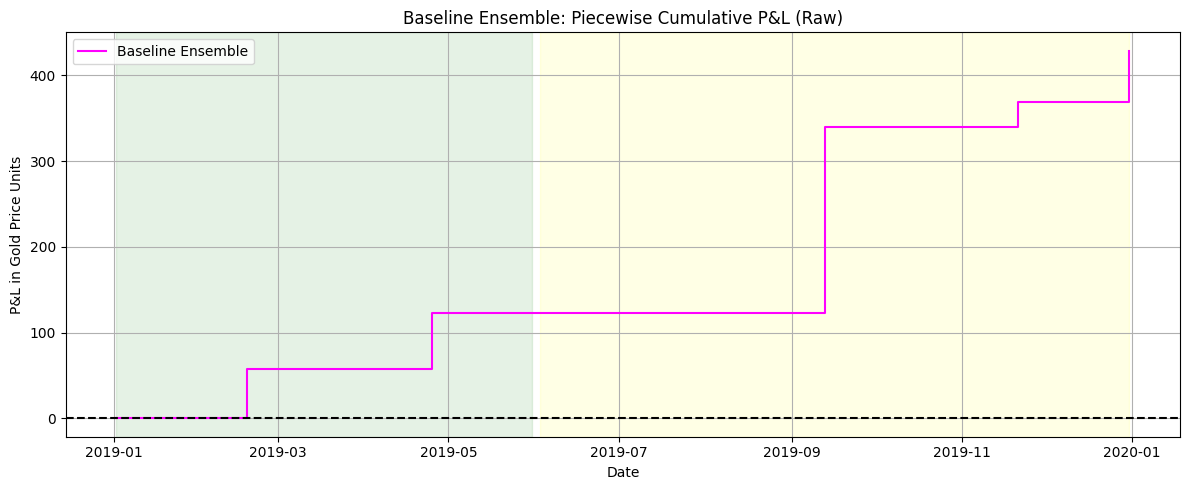

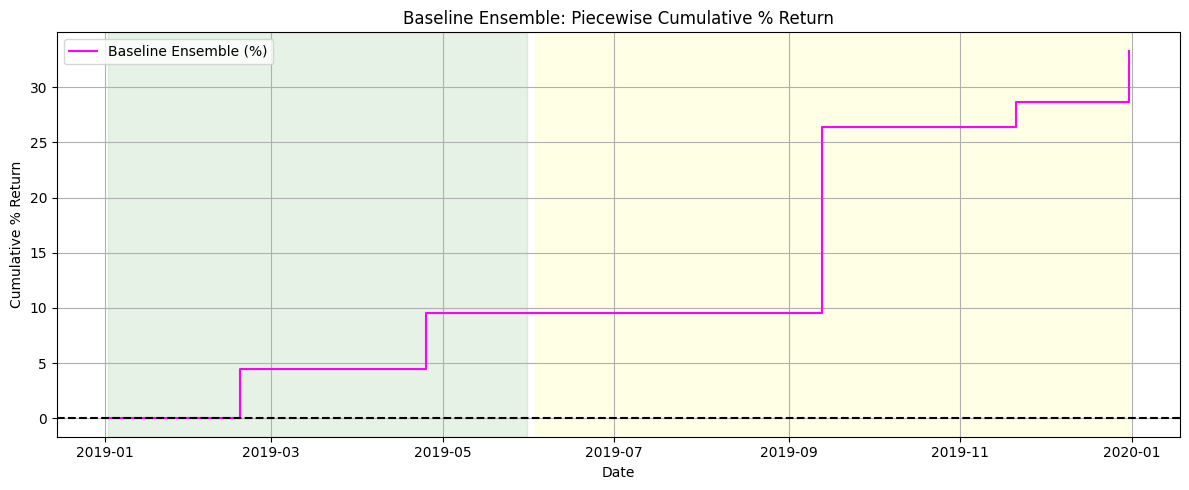

In [3]:
##############################################################################
# PIECEWISE P&L FOR BASELINE ENSEMBLE
##############################################################################

ensemble_pnl, ensemble_steps, ensemble_trades = compute_piecewise_pnl(
    ensemble_signs, 
    trade_dates, 
    actual_price_for_trading, 
    strategy_label="Baseline Ensemble"
)

print("\n===== BASELINE ENSEMBLE STRATEGY: Piecewise Trading =====")
print(f"Total trades: {ensemble_trades}")
print(f"Final P&L:    {ensemble_pnl:.2f}")

long_days_ens = np.sum(ensemble_signs == +1)
short_days_ens = np.sum(ensemble_signs == -1)
flat_days_ens = np.sum(ensemble_signs == 0)
print(f"Long days: {long_days_ens}, Short days: {short_days_ens}, Flat days: {flat_days_ens}")

# Step-plot of raw PnL
def to_step_arrays(step_points):
    return [pt[0] for pt in step_points], [pt[1] for pt in step_points]

ens_dates, ens_vals = to_step_arrays(ensemble_steps)

plt.figure(figsize=(12, 5))
plt.step(ens_dates, ens_vals, where='post', color='magenta', label='Baseline Ensemble')
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Baseline Ensemble: Piecewise Cumulative P&L (Raw)")
plt.xlabel("Date")
plt.ylabel("P&L in Gold Price Units")
plt.grid(True)
plt.legend()
plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')
plt.tight_layout()
plt.show()

# Step-plot of % returns
initial_price_ens = actual_price_for_trading[0]
ens_steps_pct = [(d, (pnl / initial_price_ens) * 100.0) for (d, pnl) in ensemble_steps]
ens_dates_pct, ens_vals_pct = to_step_arrays(ens_steps_pct)

plt.figure(figsize=(12, 5))
plt.step(ens_dates_pct, ens_vals_pct, where='post', color='magenta', label='Baseline Ensemble (%)')
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Baseline Ensemble: Piecewise Cumulative % Return")
plt.xlabel("Date")
plt.ylabel("Cumulative % Return")
plt.grid(True)
plt.legend()
plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1)
plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1)
plt.tight_layout()
plt.show()


Confidence-Based Weighting
We measure each model’s polynomial-fit MSE on a “training” subset (in your case, 75% of the val+test days).
Convert MSE to a weight via 1 / MSE. Lower MSE → higher confidence.
(Optional) Normalize weights so ∑𝑤𝑖=1

Ensemble Derivative
    For each day in validation+test, we compute the derivative of each model’s polynomial.
    Multiply each derivative by the model’s weight and sum for a single ensemble derivative.


Trade Signals

    If the weighted ensemble derivative is positive, we go long; if negative, we go short; if near zero, we stay flat.
    You can define a small threshold (like 1e-3) if you want to avoid signals on very small derivative values.

Piecewise P&L
    Using your existing compute_piecewise_pnl logic, we open or close positions whenever the signal changes.
    At the end, we also close any open position on the final day.


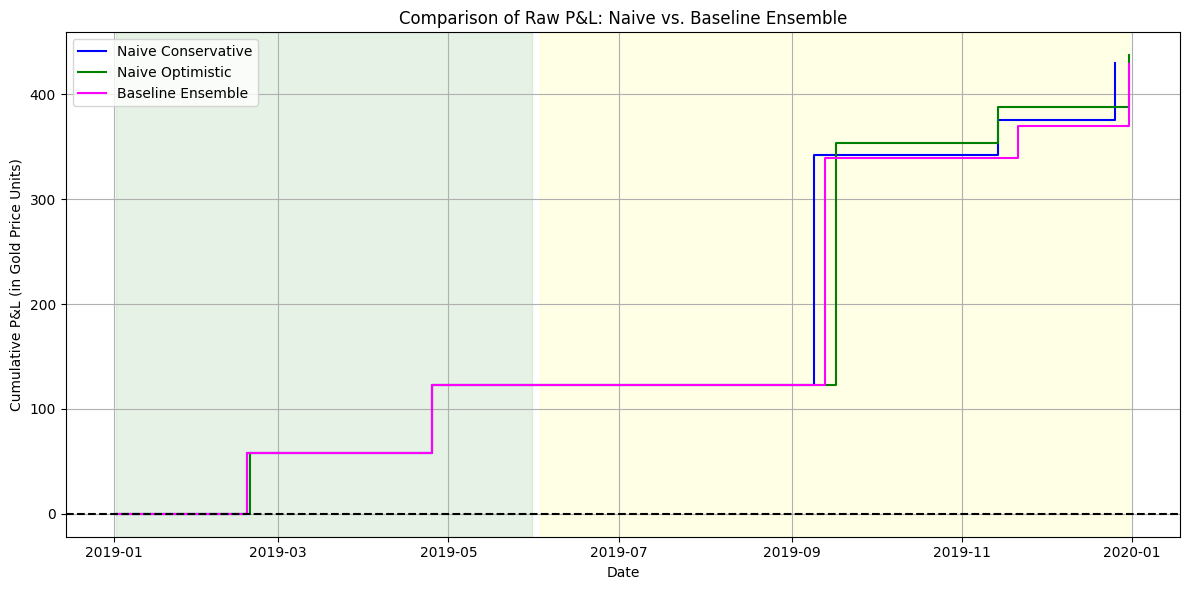

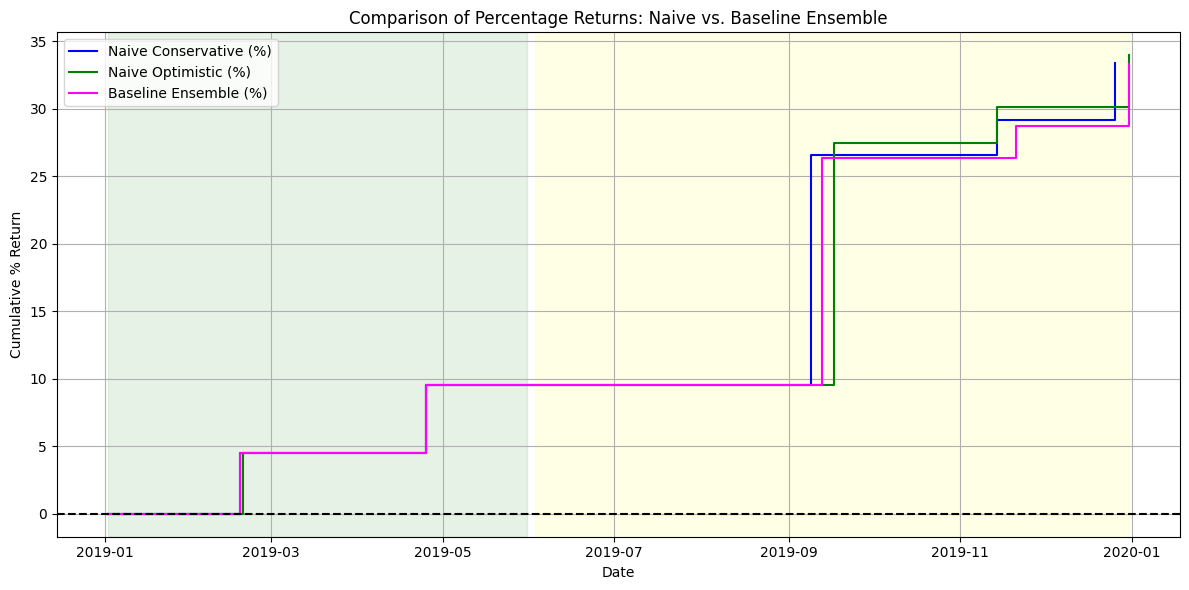

In [4]:

##############################################################################
# 2) Plot Raw P&L Comparison: 
#    Naive Conservative vs Naive Optimistic vs Baseline Ensemble
##############################################################################

def to_step_arrays(step_points):
    """
    Convert step_points = [(date1, PnL1), (date2, PnL2), ...]
    into two lists: x-dates, y-PnL.
    """
    x = [pt[0] for pt in step_points]
    y = [pt[1] for pt in step_points]
    return x, y

cons_dates, cons_vals = to_step_arrays(oneq_cons_steps)
optim_dates, optim_vals = to_step_arrays(oneq_optim_steps)
ens_dates, ens_vals = to_step_arrays(ensemble_steps)

plt.figure(figsize=(12, 6))

plt.step(cons_dates, cons_vals, where='post', label='Naive Conservative', color='blue')
plt.step(optim_dates, optim_vals, where='post', label='Naive Optimistic', color='green')
plt.step(ens_dates, ens_vals, where='post', label='Baseline Ensemble', color='magenta')

plt.axhline(y=0, color='black', linestyle='--')
plt.title("Comparison of Raw P&L: Naive vs. Baseline Ensemble")
plt.xlabel("Date")
plt.ylabel("Cumulative P&L (in Gold Price Units)")
plt.grid(True)
plt.legend()
plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')
plt.tight_layout()
plt.show()

##############################################################################
# 3) Plot Percentage Return Comparison
##############################################################################

initial_price = actual_price_for_trading[0]

def convert_to_percent(step_points, initial_price):
    """
    Convert raw PnL into percentage returns, 
    relative to the initial_price.
    """
    out = []
    for (d, raw_pnl) in step_points:
        pct = (raw_pnl / initial_price) * 100.0
        out.append((d, pct))
    return out

# Convert each strategy's step points to % returns
cons_steps_pct = convert_to_percent(oneq_cons_steps, initial_price)
optim_steps_pct = convert_to_percent(oneq_optim_steps, initial_price)
ens_steps_pct = convert_to_percent(ensemble_steps, initial_price)

# Get arrays for plotting
cons_dates_pct, cons_vals_pct = to_step_arrays(cons_steps_pct)
optim_dates_pct, optim_vals_pct = to_step_arrays(optim_steps_pct)
ens_dates_pct, ens_vals_pct = to_step_arrays(ens_steps_pct)

plt.figure(figsize=(12, 6))

plt.step(cons_dates_pct, cons_vals_pct, where='post', label='Naive Conservative (%)', color='blue')
plt.step(optim_dates_pct, optim_vals_pct, where='post', label='Naive Optimistic (%)', color='green')
plt.step(ens_dates_pct, ens_vals_pct, where='post', label='Baseline Ensemble (%)', color='magenta')

plt.axhline(y=0, color='black', linestyle='--')
plt.title("Comparison of Percentage Returns: Naive vs. Baseline Ensemble")
plt.xlabel("Date")
plt.ylabel("Cumulative % Return")
plt.grid(True)
plt.legend()
plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1)
plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1)
plt.tight_layout()
plt.show()
